## Machine learning model for predicting the price of gold

The objective of this project is to create a machine learning model that accuratly predicts the price of gold. From looking at https://www.sbcgold.com/blog/10-factors-regularly-influence-gold-prices/, we chose these feature variables as a starting point:

1) Interest rates - To account for interest rates, we took data from 'Market yield on U.S. Treasury securities at 20-year  constant maturity' (i.e. it reflects the amount of interest you pay from a tresury bond issued today in twenty years time).
Data source: https://www.federalreserve.gov/datadownload/Output.aspx?rel=H15&series=bf17364827e38702b42a58cf8eaa3f78&lastobs=&from=&to=&filetype=csv&label=include&layout=seriescolumn&type=package

2) Inflation rates - 
Data source: https://fred.stlouisfed.org/graph/fredgraph.csv?bgcolor=%23ebf3fb&chart_type=line&drp=0&fo=open%20sans&graph_bgcolor=%23ffffff&height=450&mode=fred&recession_bars=on&txtcolor=%23444444&ts=12&tts=12&width=1140&nt=0&thu=0&trc=0&show_legend=yes&show_axis_titles=yes&show_tooltip=yes&id=T10YIE&scale=left&cosd=2016-01-27&coed=2026-01-23&line_color=%230073e6&link_values=false&line_style=solid&mark_type=none&mw=3&lw=3&ost=-99999&oet=99999&mma=0&fml=a&fq=Daily&fam=avg&fgst=lin&fgsnd=2020-02-01&line_index=1&transformation=lin&vintage_date=2026-01-27&revision_date=2026-01-27&nd=2003-01-02

3) Value of the dollar - US dollar index is taken to account. Data source: https://fred.stlouisfed.org/series/DTWEXBGS

4) S&P500 - A stock market index which tracks the top 500 leading publicly listed companies in America. In a sense tracks the economic performance of USA. Source for data: https://fred.stlouisfed.org/series/SP500

5) Past gold price - It goes without saying that the price of gold the day/ a week / three months before will be colinear with the current gold price. We expect this feature to be the strongest predictor for the future price. Data source: https://freegoldapi.com/


## Other features 

Upon further research, we decided to implement the following additional features:

- University of Michigan: Consumer Sentiment - Captures consumer sentiment. Historically, low confidence has correlated with higher gold prices (source: https://www.mcoscillator.com/learning_center/weekly_chart/gold_and_consumer_sentiment_extremes/). Data source: https://fred.stlouisfed.org/series/UMCSENT

- CBOE Gold ETF Volatility Index -  Aims at capturing the market sentiment and percieved risk of the market via the volatility of the SPDR Gold Shares ETF (GLD). Data source: https://fred.stlouisfed.org/series/GVZCLS

- CBOE Volatility Index: VIX - Captures the volitility of the S&P 500 and is often used by investors as it provides a quantifiable measure  investor fear and uncertainty. Data source: https://fred.stlouisfed.org/series/VIXCLS



## Model

We intend to use multiple linear regression to model the data. In order to track the price gold tommorow/ next week/ in the next three months, We simply take the current price of gold and shift it by 1/ 7/ 31 units. This then serves as the target variable. 

For each of the model type*, we create two models- one model uses the current gold price as a feature, the other model does not include this feature.

### Model 1

Model 1 aims at predicting the price of gold tommorow. Data is not normalised and ridge regression is not applied.

### Model 2

Model 2 aims at predicting the price of gold after one week. Data is not normalised and ridge regression is not applied.

### Model 3 

Model 3 aims at predicting the price of gold in one months time. Data is not normalised and ridge regression is not applied.

### Model 4 

Model 3 aims at predicting the price of gold in three months time. Data is not normalised and ridge regression is not applied.


### Model 5

Model 4 aims at predicting the price of gold in one months time. This model however, includes the additional features mentioned above, underneath 'Other features'. Data this time is normalised and ridge regression is applied.

We also then conduct tests to verify if the level of autocorrelation between current gold prices and future (lagged) prices.


### Important notes

As we are dealing with time-series data, are approach in training and testing models have to be changed. All models are trained and tested on the first 90% portion of the data- the other ten percent is kept aside and is used only to predict prices using model 5. This approach ensures fair comparison between all models. A critical step was to change how we split the training and testing data. The conventional train-test split randomly splits the data. Since we are dealing with time-series data, this approach would lead to data leakange as the model will already have an idea of what the future looks like. This would result in a model that is overfitted. Instead, we split the data in a ratio of 67:33 (train test split). This means  models were tested on 33% of the data taken from the tailing end of the dataset which were completly unseen.


In [213]:
# Imports

import pandas as pd
import numpy as np

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.model_selection import train_test_split
import sklearn.metrics as metrics
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler

import matplotlib.pyplot as plt
import seaborn as sns

In [342]:
#importing files

interest = pd.read_csv('Interest_rates.csv')
gold = pd.read_csv('Gold_price.csv')
Inlfation_rate = pd.read_csv('Inlfation_rate.csv')
SP500 = pd.read_csv('SP500.csv')
Dollar_index = pd.read_csv('Dollar_index.csv')

### Formatting interest data

In [343]:
interest = interest[['Series Description','Market yield on U.S. Treasury securities at 20-year  constant maturity, quoted on investment basis']]
interest.rename(columns={'Market yield on U.S. Treasury securities at 20-year  constant maturity, quoted on investment basis':'interest_rates'},inplace = True)
interest.rename(columns={'Series Description':'observation_date'},inplace=True)

In [344]:
interest = interest.iloc[5:,:]
interest['observation_date'] = pd.to_datetime(interest.observation_date)

In [345]:
#Dropping ND values 
interest = interest.drop(interest[interest['interest_rates'] == 'ND'].index) 
interest['interest_rates'] = pd.to_numeric(interest.interest_rates)
interest.head(30)

,observation_date,interest_rates
5,1962-01-02,4.07
6,1962-01-03,4.07
7,1962-01-04,4.06
8,1962-01-05,4.07
9,1962-01-08,4.08
10,1962-01-09,4.08
11,1962-01-10,4.09
12,1962-01-11,4.08
13,1962-01-12,4.09
14,1962-01-15,4.10


In [346]:
#Renaming columns

gold.rename(columns={'Value':'gold_price'},inplace=True)
gold.rename(columns={'Date':'observation_date'},inplace=True)
gold['observation_date'] = pd.to_datetime(gold.observation_date)
print(gold.head(),'\n')

Inlfation_rate.rename(columns={'T10YIE':'inflation_rate'},inplace=True)
Inlfation_rate['observation_date'] = pd.to_datetime(Inlfation_rate.observation_date)
print(Inlfation_rate.head(),'\n')

SP500['observation_date'] = pd.to_datetime(SP500.observation_date)
print(SP500.head(),'\n')

Dollar_index.rename(columns={'DTWEXBGS':'dollar_value'},inplace=True)
Dollar_index['observation_date'] = pd.to_datetime(Dollar_index.observation_date)
print(Dollar_index.head(),'\n')

  observation_date  gold_price
0       2016-01-27      1116.3
1       2016-01-28      1116.1
2       2016-01-29      1116.4
3       2016-02-01      1128.0
4       2016-02-02      1127.2 

  observation_date  inflation_rate
0       2016-01-27            1.40
1       2016-01-28            1.42
2       2016-01-29            1.41
3       2016-02-01            1.40
4       2016-02-02            1.36 

  observation_date    SP500
0       2016-01-27  1882.95
1       2016-01-28  1893.36
2       2016-01-29  1940.24
3       2016-02-01  1939.38
4       2016-02-02  1903.03 

  observation_date  dollar_value
0       2016-01-27      115.5087
1       2016-01-28      115.2224
2       2016-01-29      115.5731
3       2016-02-01      115.3331
4       2016-02-02      115.5530 



## Joining data together

In [347]:
df_final = interest.merge(Inlfation_rate, on='observation_date', how='inner').merge(SP500,
on='observation_date',how='inner').merge(Dollar_index, on='observation_date',
how='inner').merge(gold, on='observation_date', how='inner')

df_copy = df_final.copy(deep=True)
'''.merge(SP500,
on='observation_date',how='inner').merge(Dollar_index, on='observation_date',
how='inner').merge(gold, on='observation_date', how='inner')'''

".merge(SP500,\non='observation_date',how='inner').merge(Dollar_index, on='observation_date',\nhow='inner').merge(gold, on='observation_date', how='inner')"

In [220]:
#Creating target variables
df_final['gold_price_tmw'] = df_final['gold_price'].shift(-1)
df_final['gold_price_nxtweek'] = df_final['gold_price'].shift(-7)
df_final['gold_price_nxtmth'] = df_final['gold_price'].shift(-30)

## Inspecting data

In [221]:
df_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2482 entries, 0 to 2481
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   observation_date    2482 non-null   datetime64[ns]
 1   interest_rates      2482 non-null   float64       
 2   inflation_rate      2482 non-null   float64       
 3   SP500               2480 non-null   float64       
 4   dollar_value        2470 non-null   float64       
 5   gold_price          2482 non-null   float64       
 6   gold_price_tmw      2481 non-null   float64       
 7   gold_price_nxtweek  2475 non-null   float64       
 8   gold_price_nxtmth   2452 non-null   float64       
dtypes: datetime64[ns](1), float64(8)
memory usage: 174.6 KB


In [222]:
df_final.head(20)

,observation_date,interest_rates,inflation_rate,SP500,dollar_value,gold_price,gold_price_tmw,gold_price_nxtweek,gold_price_nxtmth
0,2016-01-27,2.42,1.40,1882.95,115.5087,1116.3,1116.1,1157.7,1272.8
1,2016-01-28,2.41,1.42,1893.36,115.2224,1116.1,1116.4,1197.9,1259.4
2,2016-01-29,2.36,1.41,1940.24,115.5731,1116.4,1128.0,1198.6,1245.1
3,2016-02-01,2.38,1.40,1939.38,115.3331,1128.0,1127.2,1194.6,1231.0
4,2016-02-02,2.27,1.36,1903.03,115.5530,1127.2,1141.3,1247.8,1229.8
5,2016-02-03,2.30,1.38,1912.53,114.6144,1141.3,1157.5,1239.4,1265.0
6,2016-02-04,2.29,1.36,1915.45,113.6012,1157.5,1157.7,1208.2,1254.3
7,2016-02-05,2.27,1.33,1880.05,114.2935,1157.7,1197.9,1211.4,1244.2
8,2016-02-08,2.17,1.23,1853.44,114.4351,1197.9,1198.6,1226.3,1250.3
9,2016-02-09,2.16,1.21,1852.21,114.1270,1198.6,1194.6,1230.8,1225.6


In [223]:
df_final.dtypes

observation_date      datetime64[ns]
interest_rates               float64
inflation_rate               float64
SP500                        float64
dollar_value                 float64
gold_price                   float64
gold_price_tmw               float64
gold_price_nxtweek           float64
gold_price_nxtmth            float64
dtype: object

In [224]:
df_final.shape

(2482, 9)

In [225]:
df_final.isnull().sum()

observation_date       0
interest_rates         0
inflation_rate         0
SP500                  2
dollar_value          12
gold_price             0
gold_price_tmw         1
gold_price_nxtweek     7
gold_price_nxtmth     30
dtype: int64

In [226]:
df_final.dropna(inplace=True)
df_final.isnull().sum()

observation_date      0
interest_rates        0
inflation_rate        0
SP500                 0
dollar_value          0
gold_price            0
gold_price_tmw        0
gold_price_nxtweek    0
gold_price_nxtmth     0
dtype: int64

In [227]:
df_final.describe()

,observation_date,interest_rates,inflation_rate,SP500,dollar_value,gold_price,gold_price_tmw,gold_price_nxtweek,gold_price_nxtmth
count,2438,2438.000000,2438.000000,2438.000000,2438.000000,2438.000000,2438.000000,2438.00000,2438.000000
mean,2021-01-03 14:07:34.799015680,3.041054,2.055607,3768.543540,117.206680,1823.255195,1824.521156,1832.23521,1863.488625
min,2016-01-27 00:00:00,0.870000,0.500000,1829.080000,106.487700,0.000000,0.000000,0.00000,0.000000
25%,2018-07-12 06:00:00,2.140000,1.770000,2716.972500,113.324450,1303.612500,1304.087500,1305.42500,1311.287500
50%,2021-01-12 12:00:00,2.820000,2.135000,3697.140000,116.393150,1761.000000,1761.450000,1763.77230,1772.550000
75%,2023-06-25 06:00:00,4.140000,2.330000,4511.217500,121.185875,1960.412200,1960.699825,1961.97500,1972.386275
max,2025-12-09 00:00:00,5.300000,3.020000,6890.890000,130.214200,4365.315800,4365.315800,4365.31580,4988.028800
std,NaN,1.140414,0.375689,1271.555336,5.002036,639.357125,641.049958,651.80651,700.036920


## Visualisation

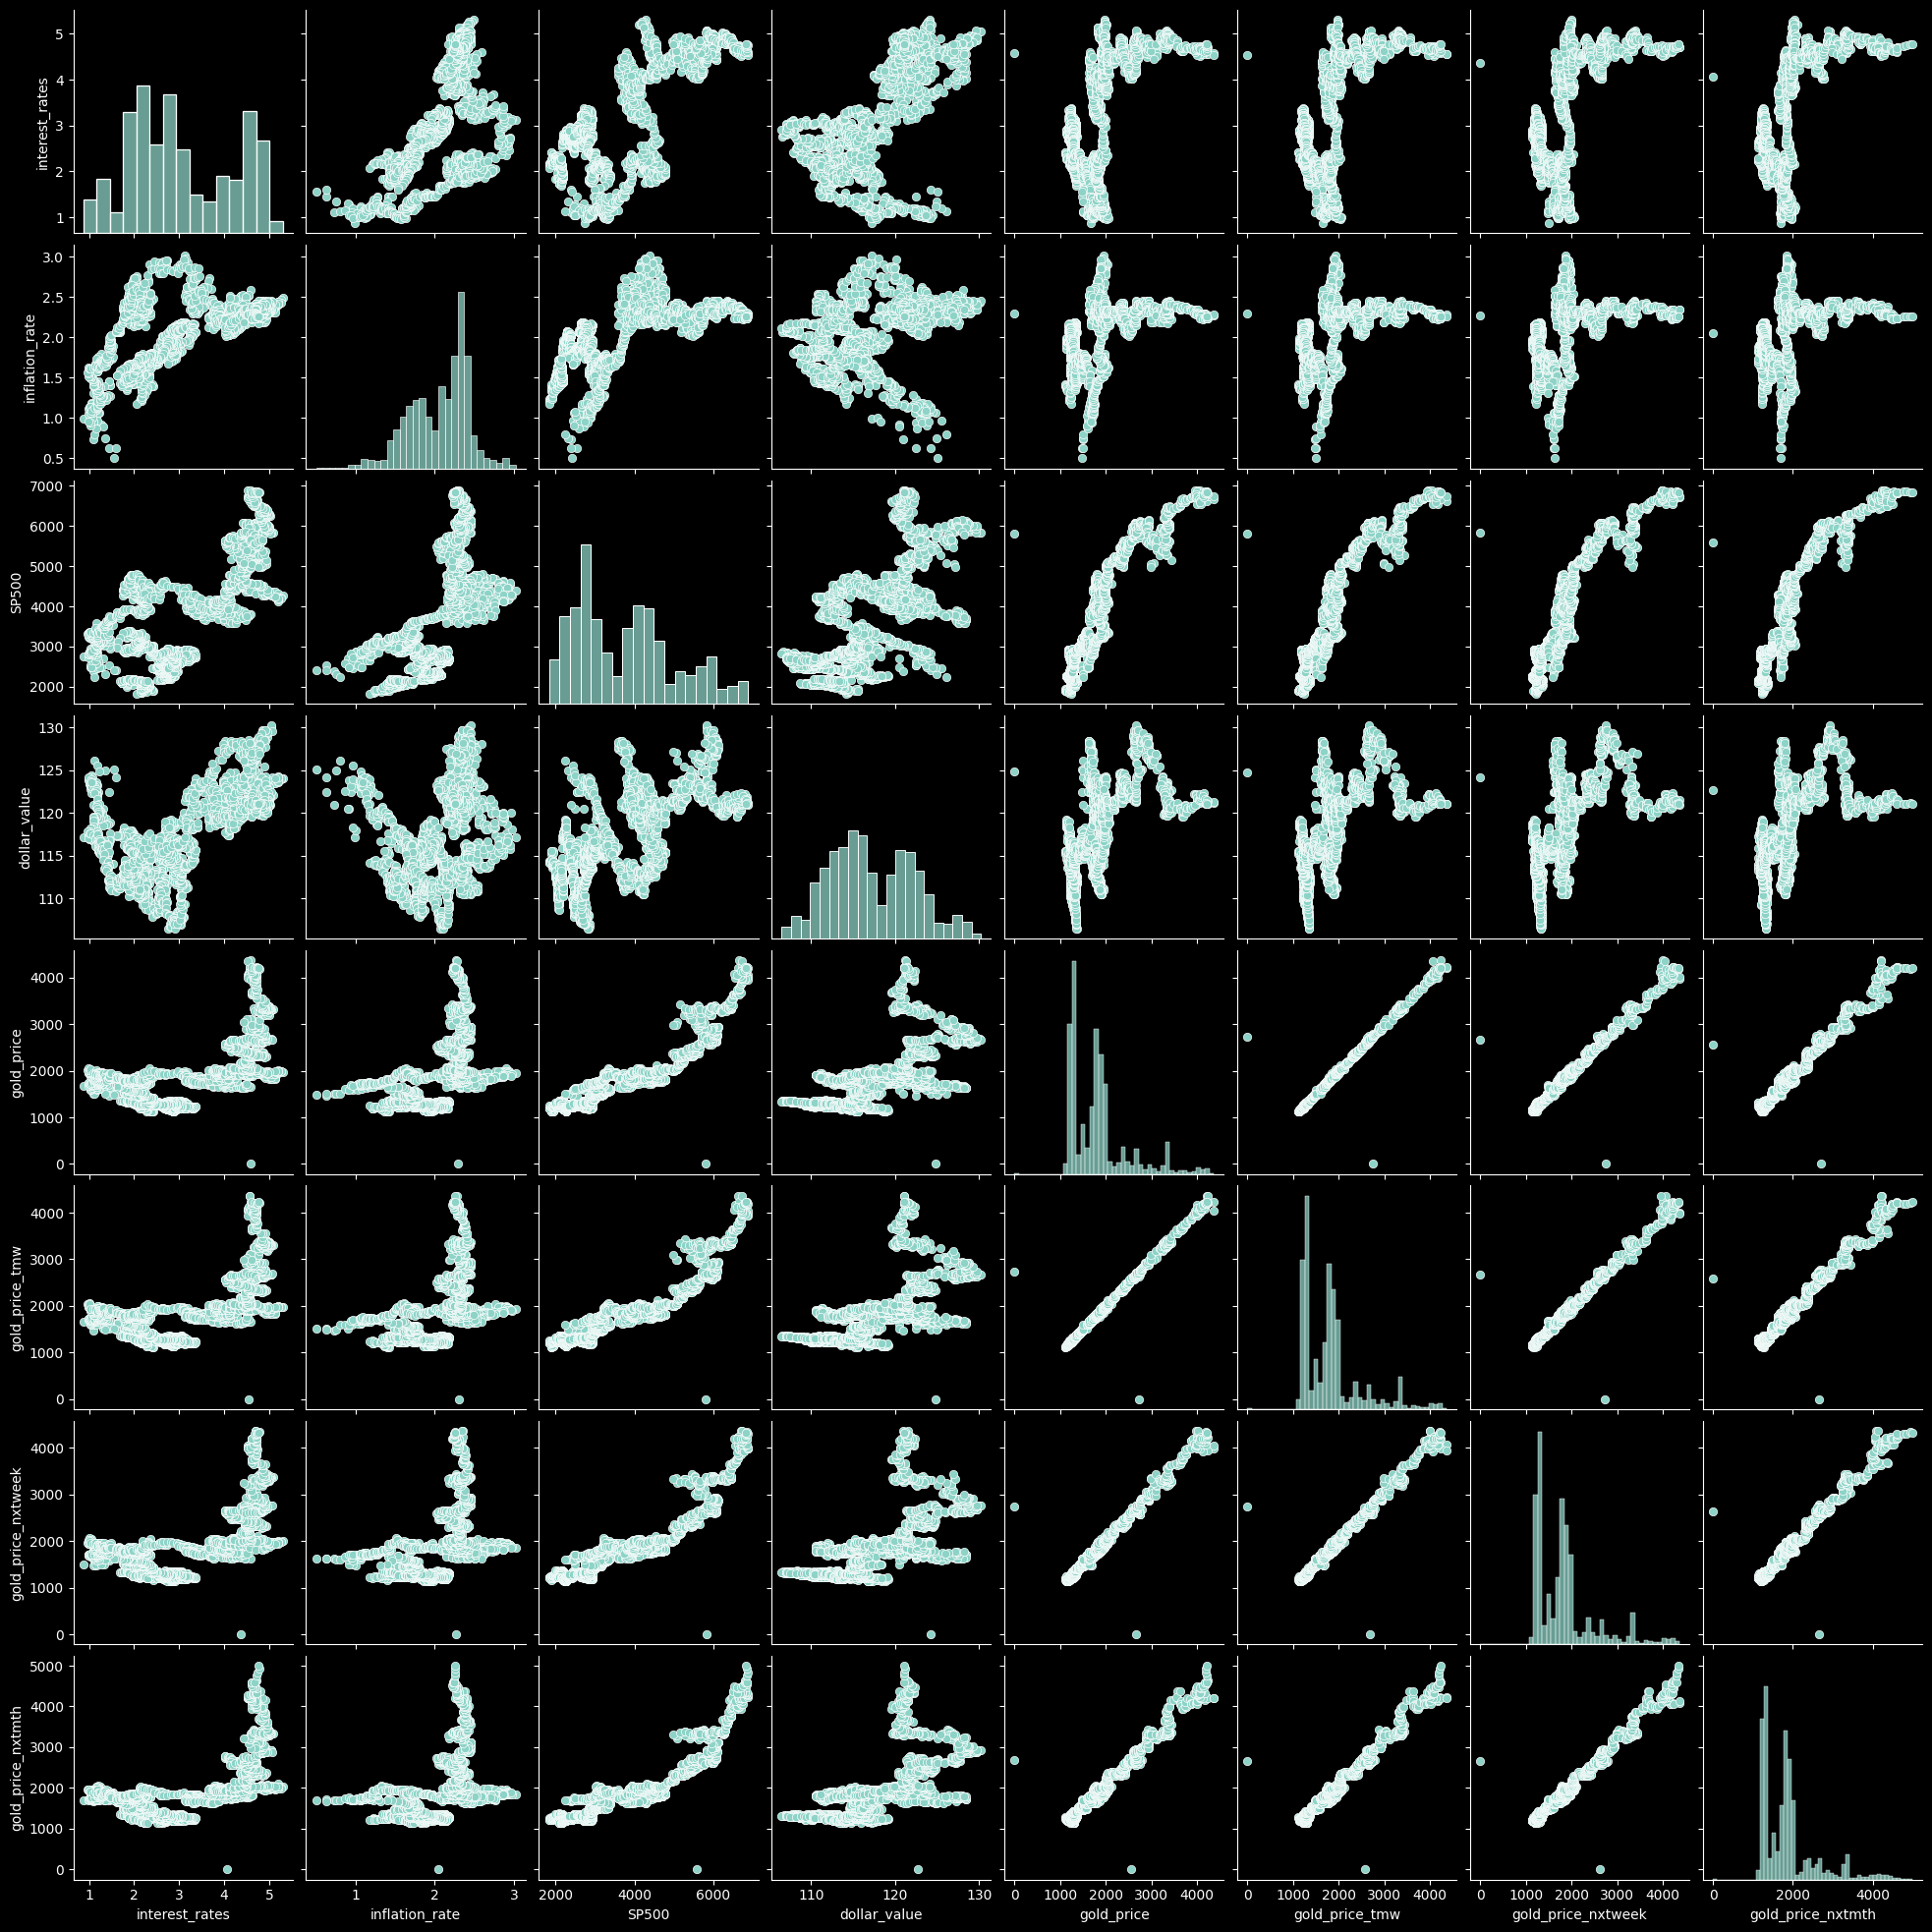

In [228]:
sns.pairplot(df_final)

From the pairplot, we can see signs of multicollinearity between the interest and inflation rates. 

<Axes: >

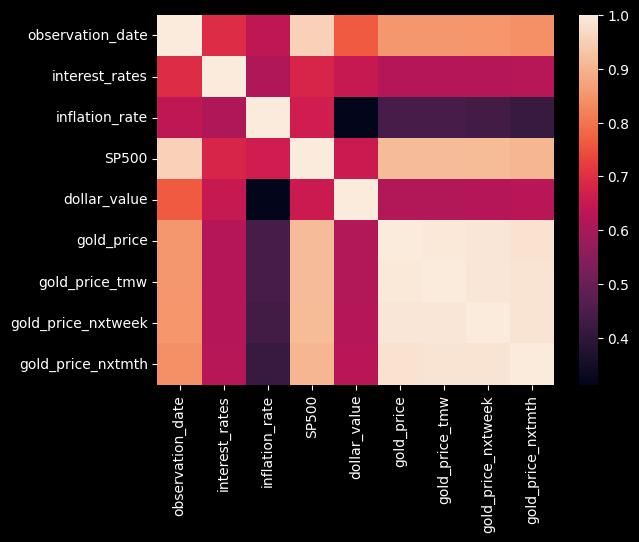

In [229]:
#correlation plot
sns.heatmap(df_final.corr())

In [230]:
df_final.corr()

,observation_date,interest_rates,inflation_rate,SP500,dollar_value,gold_price,gold_price_tmw,gold_price_nxtweek,gold_price_nxtmth
observation_date,1.000000,0.694343,0.636064,0.952637,0.763202,0.853446,0.853081,0.850547,0.840222
interest_rates,0.694343,1.000000,0.609329,0.681528,0.648778,0.617462,0.617644,0.619107,0.622879
inflation_rate,0.636064,0.609329,1.000000,0.663044,0.313155,0.443640,0.442688,0.436532,0.416912
SP500,0.952637,0.681528,0.663044,1.000000,0.656022,0.916308,0.915976,0.913625,0.906081
dollar_value,0.763202,0.648778,0.313155,0.656022,1.000000,0.613761,0.614352,0.617906,0.625208
gold_price,0.853446,0.617462,0.443640,0.916308,0.613761,1.000000,0.991957,0.989648,0.983736
gold_price_tmw,0.853081,0.617644,0.442688,0.915976,0.614352,0.991957,1.000000,0.990014,0.984185
gold_price_nxtweek,0.850547,0.619107,0.436532,0.913625,0.617906,0.989648,0.990014,1.000000,0.986052
gold_price_nxtmth,0.840222,0.622879,0.416912,0.906081,0.625208,0.983736,0.984185,0.986052,1.000000


As expected, the future gold price is heavily correlated to its current price. We note that all other metrics show reasonable correlation with future gold prices, with inflation having the smallest r value of roughly 0.4.

## Model 1: predicting price of gold tomorrow

In [335]:
train_size = int(0.9 * len(df_final))
train_test_set, untouched_set = np.split(df_final, [train_size])

#For fair comparison models will only be trained and tested on the first 90% of data



c:\Users\rahma\AppData\Local\Programs\Python\Python313\Lib\site-packages\numpy\_core\fromnumeric.py:57: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


In [ ]:
# Create a new regressor object for MLR 
# Train the new regressor
mlr_tmw = LinearRegression()
train_size = int(0.67 * len(train_test_set))
train_set, test_set = np.split(train_test_set, [train_size])
X_train = train_set.iloc[:,1:6]
y_train = train_set[['gold_price_tmw']]
X_test = test_set.iloc[:,1:6]
y_test = test_set[['gold_price_tmw']]
mlr_tmw.fit(X_train,y_train)

c:\Users\rahma\AppData\Local\Programs\Python\Python313\Lib\site-packages\numpy\_core\fromnumeric.py:57: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


,fit_intercept,True
,copy_X,True
,tol,1e-06
,n_jobs,None
,positive,False


In [301]:
#checking intercept & coeficients
print(mlr_tmw.intercept_)
print(mlr_tmw.coef_)

[7.66096566]
[[-8.05060773e+00  3.52278060e+00  4.49893564e-03  2.78315991e-01
   9.72328224e-01]]


C:\Users\rahma\AppData\Local\Temp\ipykernel_37128\23990740.py:5: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(y_test,Y_pred, cmap='Paired')


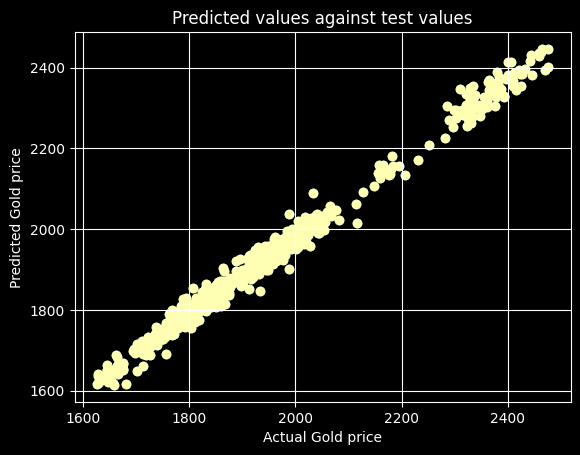

In [320]:
Y_pred = mlr_tmw.predict(X_test)
plt.scatter(y_test,Y_pred)
cmap = plt.get_cmap('Paired')
plt.style.use('dark_background')
plt.scatter(y_test,Y_pred, cmap='Paired')
plt.xlabel("Actual Gold price")
plt.ylabel("Predicted Gold price")
plt.title("Predicted values against test values")
plt.grid(True)

In [303]:
# Create print statements for MAE MSE and RMSE.
# In context... are our scores good or bad? 
# Look at their formulas in order to determine their success.
# Evaluation metrics
from sklearn.metrics import mean_absolute_error

mse1 = mean_squared_error(y_test, Y_pred)
rmse1 = np.sqrt(mse1)
r_squared1 = r2_score(y_test, Y_pred)
mae1 = mean_absolute_error(y_test, Y_pred)
print('MSE: ',mse1)
print('RMSE: ', rmse1)
print('MAE: ', mae1)
print('R2:',r_squared1)

MSE:  691.3577220456551
RMSE:  26.293682169784724
MAE:  20.974575093547866
R2: 0.9824608973090585


## model 1.1: removing gold prices
-Gold prices takes a majority weight in the linear model, such that the other features are made redundant.

In [322]:
#defining a function so that we can quickly create models

train_size = int(0.67 * len(train_test_set))
train_set, test_set = np.split(train_test_set, [train_size])


def MLR(x_train,y_train, x_test, y_test):

    mlr = LinearRegression()

    mlr.fit(x_train,y_train)



    print(mlr.intercept_)
    for index, coef in enumerate(mlr.coef_):
      print(x_train.columns[index], coef)

    Y_pred = mlr.predict(x_test)
    cmap = plt.get_cmap('Paired')
    plt.style.use('dark_background')
    plt.scatter(y_test,Y_pred)
    plt.scatter(y_test,Y_pred, cmap='Paired')
    plt.xlabel("Actual Gold price ")
    plt.ylabel("Predicted Gold price ")
    plt.title("Predicted values against test values")
    plt.grid(True)



    mse1 = mean_squared_error(y_test, Y_pred)
    rmse1 = np.sqrt(mse1)
    r_squared1 = r2_score(y_test, Y_pred)
    mae1 = mean_absolute_error(y_test, Y_pred)
    print('MSE: ',mse1)
    print('RMSE: ', rmse1)
    print('MAE: ', mae1)
    print('R2:',r_squared1)

    return mlr

    

1488.8323015072615
interest_rates -278.3986462782543
inflation_rate 93.85529531987031
SP500 0.18851893001517503
dollar_value -1.0832239580694174
MSE:  477066.7139125711
RMSE:  690.7001620910271
MAE:  620.3484216987598
R2: -11.102739029202631


C:\Users\rahma\AppData\Local\Temp\ipykernel_37128\1788395838.py:23: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(y_test,Y_pred, cmap='Paired')


,fit_intercept,True
,copy_X,True
,tol,1e-06
,n_jobs,None
,positive,False


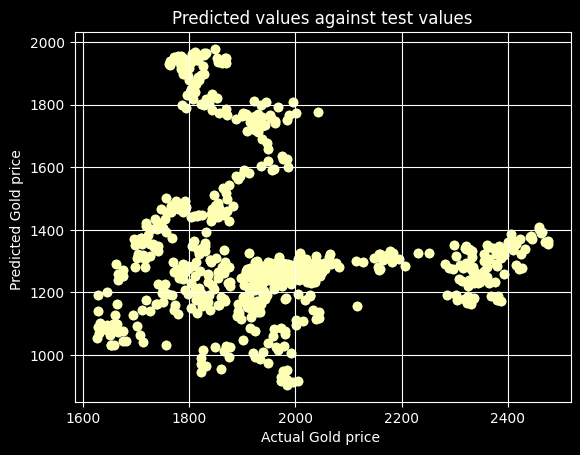

In [330]:
x1_2_train = train_set.iloc[:,1:5]
y1_tmw_train = train_set.iloc[:,-4]
x1_2_test = test_set.iloc[:,1:5]
y1_tmw_test = test_set.iloc[:,-4]
MLR(x1_2_train,y1_tmw_train, x1_2_test, y1_tmw_test)

## Model 2: modelling price prediction for gold in the next week

In [327]:
x1_1_train = train_set.iloc[:,1:6]
y_wk_train = train_set['gold_price_nxtweek']
x1_1_test = test_set.iloc[:,1:6]
y_wk_test = test_set['gold_price_nxtweek']

Model using current gold prices

-16.99661325477996
interest_rates -13.250610343298504
inflation_rate -24.071201499214446
SP500 0.031426447109702646
dollar_value 1.3764889933546127
gold_price 0.8940255248385188
MSE:  3522.2023400526127
RMSE:  59.34814521156169
MAE:  46.27667549654157
R2: 0.9156969369581951


C:\Users\rahma\AppData\Local\Temp\ipykernel_37128\1788395838.py:23: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(y_test,Y_pred, cmap='Paired')


,fit_intercept,True
,copy_X,True
,tol,1e-06
,n_jobs,None
,positive,False


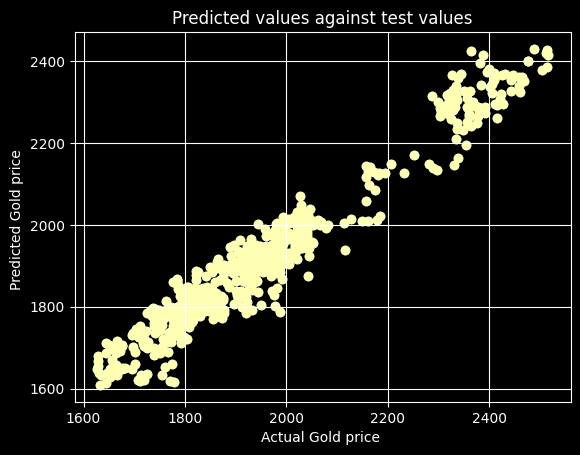

In [ ]:
MLR(x1_1_train,y_wk_train,x1_1_test, y_wk_test)

Model without using current gold prices

1344.8943081649697
interest_rates -261.8272134775028
inflation_rate 58.98673294182615
SP500 0.20062710177540935
dollar_value 0.12459540670030199
MSE:  431331.15709672694
RMSE:  656.758065878697
MAE:  589.1201264403657
R2: -9.323807157562914


C:\Users\rahma\AppData\Local\Temp\ipykernel_37128\1788395838.py:23: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(y_test,Y_pred, cmap='Paired')


,fit_intercept,True
,copy_X,True
,tol,1e-06
,n_jobs,None
,positive,False


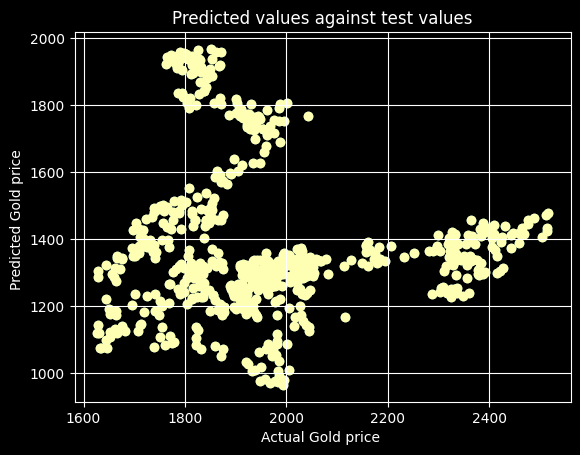

In [331]:
MLR(x1_2_train,y_wk_train,x1_2_test, y_wk_test)

## Modelling gold price next month

In [332]:
y_mnth_test = test_set[['gold_price_nxtmth']]
y_mnth_train = train_set[['gold_price_nxtmth']]

Including current gold prices

[-138.00299532]
interest_rates [ 3.44801851e+00 -1.48107391e+02  1.19719843e-01  4.12805926e+00
  7.21714665e-01]
MSE:  6288.104785555105
RMSE:  79.2975711201491
MAE:  63.14349055133145
R2: 0.8800505333066087


C:\Users\rahma\AppData\Local\Temp\ipykernel_37128\1788395838.py:23: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(y_test,Y_pred, cmap='Paired')


,fit_intercept,True
,copy_X,True
,tol,1e-06
,n_jobs,None
,positive,False


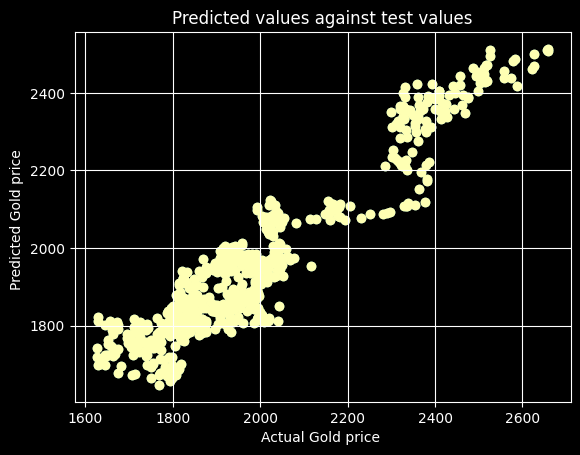

In [333]:
MLR(x1_1_train,y_mnth_train,x1_1_test,y_mnth_test)

Modelling without current gold prices

[961.40258394]
interest_rates [-197.21893658  -81.05770632    0.25630945    3.11745057]
MSE:  279686.3809550578
RMSE:  528.8538370429563
MAE:  471.728569841959
R2: -4.3351897560661055


C:\Users\rahma\AppData\Local\Temp\ipykernel_37128\1788395838.py:23: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(y_test,Y_pred, cmap='Paired')


,fit_intercept,True
,copy_X,True
,tol,1e-06
,n_jobs,None
,positive,False


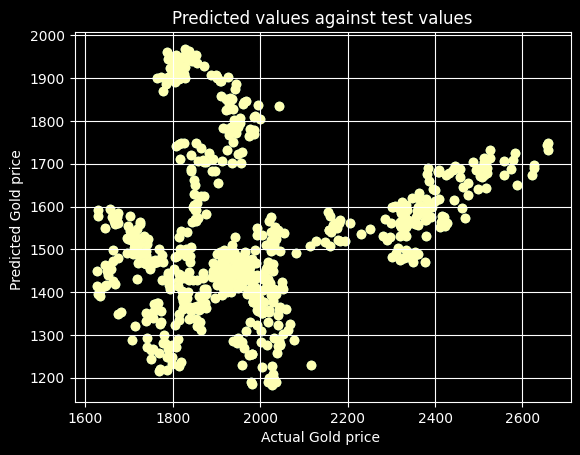

In [334]:
MLR(x1_2_train,y_mnth_train,x1_2_test,y_mnth_test)

## Model 4: Predicting gold price after 3 months

In [ ]:
df_final2 = train_test_set
df_final2['gold_price_3mnth'] = df_final2['gold_price'].shift(-91)
df_final2.dropna(inplace=True)
df_final2 = df_final2[df_final2['gold_price_3mnth'] >= 1000]
df_final2 = df_final2.drop(df_final2[df_final2['gold_price_3mnth'] < 1000].index) 

In [336]:
train_size = int(0.67 * len(df_final2))
train_set, test_set = np.split(df_final2, [train_size])
X_train_1 = train_set.iloc[:,1:6]
X_train_2 = train_set.iloc[:,1:5]
y_train_3mnth = train_set[['gold_price_3mnth']]
X_test_1 = test_set.iloc[:,1:6]
X_test_2 = test_set.iloc[:,1:5]
y_test_3mnth = test_set[['gold_price_3mnth']]


c:\Users\rahma\AppData\Local\Programs\Python\Python313\Lib\site-packages\numpy\_core\fromnumeric.py:57: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


[-572.927448]
interest_rates [-5.44985654e+01 -2.46316862e+02  2.77765296e-01  1.34920193e+01
  2.00787070e-01]
MSE:  328459.900852209
RMSE:  573.114212746647
MAE:  424.56742210777554
R2: 0.2639894224926935


C:\Users\rahma\AppData\Local\Temp\ipykernel_37128\1788395838.py:23: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(y_test,Y_pred, cmap='Paired')


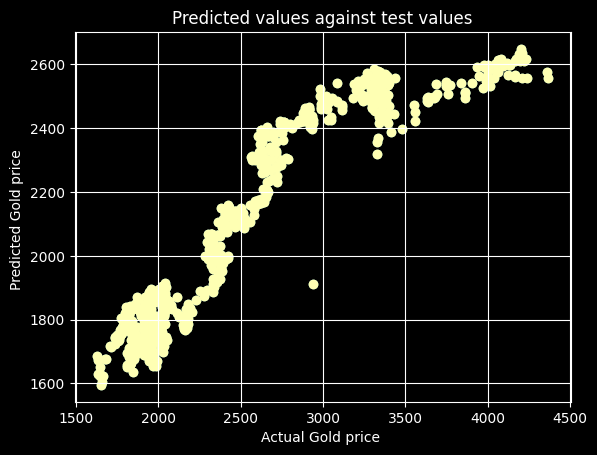

In [337]:
mlr4_1 = MLR(X_train_1,y_train_3mnth,X_test_1,y_test_3mnth )


[-505.81371854]
interest_rates [-106.84187206 -209.01887981    0.31217433   15.03238502]
MSE:  577220.3269180628
RMSE:  759.7501740164741
MAE:  595.8720555106066
R2: -0.293431146577241


C:\Users\rahma\AppData\Local\Temp\ipykernel_37128\1788395838.py:23: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(y_test,Y_pred, cmap='Paired')


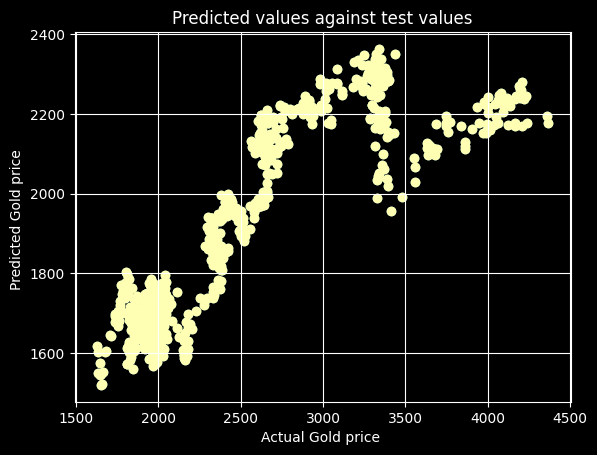

In [338]:
mlr4_2 = MLR(X_train_2,y_train_3mnth,X_test_2,y_test_3mnth)

# Comments on models 1 to 4

As we expected, as the shift of the gold price being predicted increased, the R2 score decreased quite significantly- we this visually represented by the graphs showing the predicted values against the test actual values. For instance, we see a jump from 79 to 573 in the RMSE when moving from model 3 (which predicts prices in 1 month) and model 4 (which predicts prices in 3 months). As model 3 has an R2 of 0.88, we will continue experiment with predicting the price of gold in 1 month.

Predicting the price of gold without the gold feature itself leads to a very weak model- the R2 scores are negative across all models, indicating that the model is performing worse than a model that takes the mean of the target variable. 

## Experimental (model 5)
Adding an extra features- consumer sentiment score, VIX score and gold volatility. Will look at making predictions in the next 3 months. In addition, this time we will normalise and apply ridge regression normalisation.

In [437]:
consumer_sentiment = pd.read_csv('UMCSENT.csv')
consumer_sentiment.rename(columns={'observation_date':'observation_date_month'},inplace=True)

VIX_score = pd.read_csv('VIXCLS.csv')
Gold_volatility = pd.read_csv('GVZCLS.csv')

In [438]:
consumer_sentiment['observation_date_month'] = pd.to_datetime(consumer_sentiment.observation_date_month)
VIX_score['observation_date'] = pd.to_datetime(VIX_score.observation_date)
Gold_volatility['observation_date'] = pd.to_datetime(Gold_volatility.observation_date)

In [481]:
df_final3 = df_copy.copy(deep=True)

In [482]:
df_final3['observation_date_month'] = df_final3['observation_date'].dt.to_period('M').dt.to_timestamp()

In [483]:
df_final3 = df_final3.merge(consumer_sentiment, on='observation_date_month', how='inner')
df_final3 = df_final3.merge(VIX_score, on='observation_date', how='inner').merge(Gold_volatility, on='observation_date', how='inner')

df_final3.dropna(subset=['SP500', 'dollar_value'], how='any',inplace=True)



In [484]:
df_final3.isnull().sum()

observation_date          0
interest_rates            0
inflation_rate            0
SP500                     0
dollar_value              0
gold_price                0
observation_date_month    0
UMCSENT                   0
VIXCLS                    0
GVZCLS                    0
dtype: int64

In [411]:
df_final3

,observation_date,interest_rates,inflation_rate,SP500,dollar_value,gold_price,observation_date_month,UMCSENT,VIXCLS,GVZCLS
0,2016-01-27,2.42,1.40,1882.95,115.5087,1116.3000,2016-01-01,92.0,23.11,16.71
1,2016-01-28,2.41,1.42,1893.36,115.2224,1116.1000,2016-01-01,92.0,22.42,15.41
2,2016-01-29,2.36,1.41,1940.24,115.5731,1116.4000,2016-01-01,92.0,20.20,15.73
3,2016-02-01,2.38,1.40,1939.38,115.3331,1128.0000,2016-02-01,91.7,19.98,16.81
4,2016-02-02,2.27,1.36,1903.03,115.5530,1127.2000,2016-02-01,91.7,21.98,16.20
...,...,...,...,...,...,...,...,...,...,...
2462,2025-12-24,4.75,2.24,6932.05,119.8262,4479.4438,2025-12-01,52.9,13.47,23.81
2463,2025-12-26,4.76,2.23,6929.94,119.8529,4533.5643,2025-12-01,52.9,13.60,25.78
2464,2025-12-29,4.75,2.22,6905.74,119.9679,4332.2864,2025-12-01,52.9,14.20,25.71
2465,2025-12-30,4.76,2.24,6896.24,119.8754,4339.1196,2025-12-01,52.9,14.33,24.83


In [412]:
df_final3.corr()

,observation_date,interest_rates,inflation_rate,SP500,dollar_value,gold_price,observation_date_month,UMCSENT,VIXCLS,GVZCLS
observation_date,1.000000,0.699083,0.634992,0.952493,0.761845,0.847562,0.999965,-0.843804,0.193324,0.275182
interest_rates,0.699083,1.000000,0.609175,0.686860,0.649173,0.620496,0.699009,-0.540115,-0.213774,-0.105188
inflation_rate,0.634992,0.609175,1.000000,0.658087,0.314412,0.434800,0.634981,-0.583630,-0.125013,-0.119220
SP500,0.952493,0.686860,0.658087,1.000000,0.652700,0.915071,0.952462,-0.780069,0.051510,0.242860
dollar_value,0.761845,0.649173,0.314412,0.652700,1.000000,0.599726,0.761761,-0.695053,0.294406,0.329298
gold_price,0.847562,0.620496,0.434800,0.915071,0.599726,1.000000,0.847522,-0.744472,0.116982,0.409747
observation_date_month,0.999965,0.699009,0.634981,0.952462,0.761761,0.847522,1.000000,-0.843845,0.193399,0.275254
UMCSENT,-0.843804,-0.540115,-0.583630,-0.780069,-0.695053,-0.744472,-0.843845,1.000000,-0.339178,-0.478857
VIXCLS,0.193324,-0.213774,-0.125013,0.051510,0.294406,0.116982,0.193399,-0.339178,1.000000,0.713245
GVZCLS,0.275182,-0.105188,-0.119220,0.242860,0.329298,0.409747,0.275254,-0.478857,0.713245,1.000000


 - The VIX score shows weak level of correlation with the future prices of gold. Gold volatility (GVZCLS) shows improved correlation as we might expect but still remains quite low at ~0.3. Consumer sentiment score (UMCSENT) shows a very correlation with -0.7, indicating that as consumer sentiment rises, gold prices deacrease.

In [485]:
#df_final3 = df_final3[df_final3['gold_price'] <100]
df_final3.drop(df_final3[df_final3['gold_price'] == 0].index, inplace=True)
df_final3['gold_price_mnth'] = df_final3['gold_price'].shift(-30)
train_size_5 = int(0.9 * len(df_final3))
train_test_set_5, untouched_set_5 = np.split(df_final3, [train_size_5])

c:\Users\rahma\AppData\Local\Programs\Python\Python313\Lib\site-packages\numpy\_core\fromnumeric.py:57: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


In [486]:
train_test_set_5.isnull().sum()

observation_date          0
interest_rates            0
inflation_rate            0
SP500                     0
dollar_value              0
gold_price                0
observation_date_month    0
UMCSENT                   0
VIXCLS                    0
GVZCLS                    0
gold_price_mnth           0
dtype: int64

In [487]:
train_size = int(0.67 * len(train_test_set_5))
train_set, test_set = np.split(train_test_set_5, [train_size])

In [488]:
X_train_1 = train_set[['interest_rates','inflation_rate','SP500','dollar_value','gold_price','UMCSENT','VIXCLS','GVZCLS']]

y_train_mnth = train_set[['gold_price_mnth']]
X_test_1 = test_set[['interest_rates','inflation_rate','SP500','dollar_value','gold_price','UMCSENT','VIXCLS','GVZCLS']]

y_test_mnth = test_set[['gold_price_mnth']]

Before running the ridge regression function, we first need to find the optimal value for alpha. To do this, we 

In [ ]:
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge, Lasso
from sklearn.metrics import mean_squared_error
import numpy as np

tscv = TimeSeriesSplit(n_splits=5)
X = train_test_set_5[['interest_rates','inflation_rate','SP500','dollar_value','gold_price','UMCSENT','VIXCLS','GVZCLS']]
y = train_test_set_5[['gold_price_mnth']]
alphas = [0.1, 1, 5, 10, 50, 100]
alpha_scores = {}

for alpha in alphas:
    fold_errors = []
    
    for train_idx, test_idx in tscv.split(X):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

        # scale inside each fold (important!)
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled  = scaler.transform(X_test)

        model = Ridge(alpha=alpha)
        model.fit(X_train_scaled, y_train)

        y_pred = model.predict(X_test_scaled)
        fold_errors.append(mean_squared_error(y_test, y_pred))

    alpha_scores[alpha] = np.mean(fold_errors)



best_alpha = min(alpha_scores, key=alpha_scores.get)
print("\nBest alpha:", best_alpha)


Best alpha: 0.1


In [492]:
# Creating an augmented MLR function that includes ridge regression 

def MLR_ridge(x_train, y_train, x_test, y_test):

    mlr = Ridge(alpha=0)
    
    feature_scaler = StandardScaler()
    scaler3 = StandardScaler()
    scaler3.fit(x_train)               # fit ONLY on training data

    X_train_scaled = scaler3.transform(x_train)
    X_test_scaled  = scaler3.transform(x_test)
    mlr.fit(X_train_scaled,y_train)



    print(mlr.intercept_)
    for index, coef in enumerate(mlr.coef_):
     print(x_train.columns[index], coef)
    y_test_array = y_test.values.ravel()
    Y_pred = mlr.predict(X_test_scaled)
    y_test_array = y_test.values.ravel()
    residual = y_test_array - Y_pred
    #cmap = plt.get_cmap('Set2')
    plt.style.use('dark_background')
    plt.scatter(y_test,Y_pred)
    plt.xlabel("Actual Gold price in a month")
    plt.ylabel("Predicted Gold price in a month")
    plt.title("Predicted values against actual values")
    plt.grid(True)


    mse1 = mean_squared_error(y_test, Y_pred)
    rmse1 = np.sqrt(mse1)
    r_squared1 = r2_score(y_test, Y_pred)
    mae1 = mean_absolute_error(y_test, Y_pred)
    print('\n')
    print('MSE: ',mse1)
    print('RMSE: ', rmse1)
    print('MAE: ', mae1)
    print('R2:',r_squared1)

    return mlr, scaler3, residual 

In [490]:
df_final3['gold_price_mnth'].min() 

np.float64(1129.8)

Model with current price of gold as feature, using ridge regression:
[1480.18104195]
interest_rates -4.199423603204001
inflation_rate -43.70970378322334
SP500 86.0057038496066
dollar_value 10.714545816120532
gold_price 171.6006718956574
UMCSENT -1.6783389584578345
VIXCLS 15.57099469181829
GVZCLS -5.640484345336816


MSE:  11694.528332416654
RMSE:  108.14124251374521
MAE:  83.67294900821071
R2: 0.8880502484340258




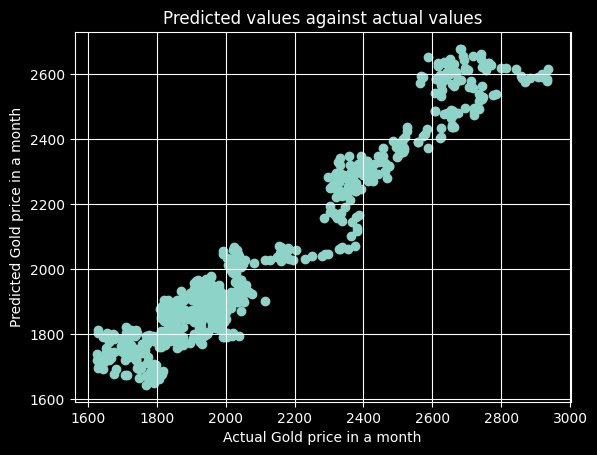

In [491]:
print('Model with current price of gold as feature, using ridge regression:')
mlr5_1, scaler1 , residual1= MLR_ridge(X_train_1,y_train_mnth,X_test_1,y_test_mnth)
print('\n')


This model (model 5.1) has a slightly better R2 than the R2 in model 3.1 (0.888 vs 0.88). However, the RMSE error is greater in model 5.1 (108 against 79). This indicates that model 5.1 generalizes the data better, however ultimatly fails to make the better predictions. It may be due to noise introduced via the new feature variables, or because of ridge regression penalising the larger weights (i.e the current gold price). By changing the alpha value to zero (analogous to linear regression), we get:

Model with current price of gold as feature, using ridge regression:
[1480.18104195]
interest_rates -4.000369089742808
inflation_rate -43.83982481332556
SP500 86.0113431414868
dollar_value 10.710814670209414
gold_price 171.77746521938224
UMCSENT -1.7007107866783282
VIXCLS 15.524001085620775
GVZCLS -5.614637869324742


MSE:  11551.882241713454
RMSE:  107.47968292525547
MAE:  83.12732225107253
R2: 0.8894157754533426




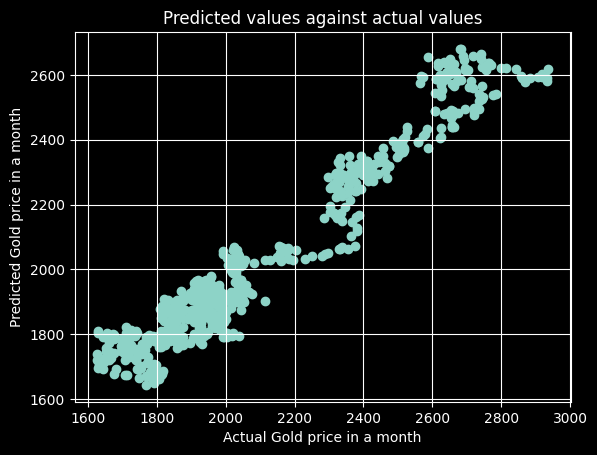

In [493]:
print('Model with current price of gold as feature, using ridge regression:')
mlr5_1, scaler1 , residual1= MLR_ridge(X_train_1,y_train_mnth,X_test_1,y_test_mnth)
print('\n')

The R2 value slightly improves even more without ridge regression, but the RMSE score still remains high.

#### Plotting the model predictions on the untouched data using model 5.1 (ridge alpha set to 0)

In [496]:
features_scaled = scaler1.transform(untouched_set_5[['interest_rates','inflation_rate','SP500','dollar_value','gold_price','UMCSENT','VIXCLS','GVZCLS']])
untouched_set_5['gold_price_mnth_model5.1'] = mlr5_1.predict(features_scaled)

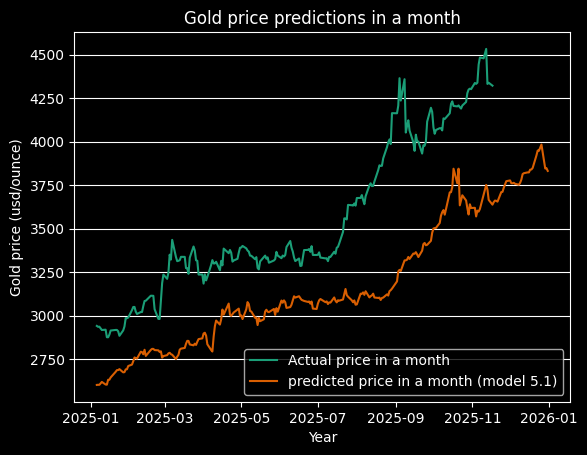

In [501]:
cmap = plt.get_cmap('Dark2')
plt.style.use('dark_background')
plt.plot(untouched_set_5[['observation_date']],untouched_set_5[['gold_price_mnth']], label = 'Actual price in a month', color=cmap(0))
plt.plot(untouched_set_5[['observation_date']],untouched_set_5['gold_price_mnth_model5.1'], label = 'predicted price in a month (model 5.1)', color=cmap(1))

plt.xlabel("Year")
plt.ylabel("Gold price (usd/ounce)")
plt.title("Gold price predictions in a month")
plt.grid(axis = 'y')
plt.legend()


## Model evaluation of model 5.1 on untouched data

We can see that predicted price has a distinctive shift across the entire year from the actual price in 3 months. This is perhaps a reflection of the model inability to capture the volatile nature of gold prices in recent years where we have seen sudden surges in price.

We can also make out from the plot itself signs of autocorrelation; the shapes of the peaks and dips in the actual price in one month emerges in the predicted price in one month. To confirm that there is indeed autocorrelation, we can conduct the durbin watson hypthesis test and also plot an ACF plot:

#### Durbin Watson test

In [502]:
from statsmodels.stats.stattools import durbin_watson

In [503]:
print('Durbin watson test on model 5.1: ',durbin_watson(residual1),'\n')

Durbin watson test on model 5.1:  0.051917914883088244 



#### ACF plot

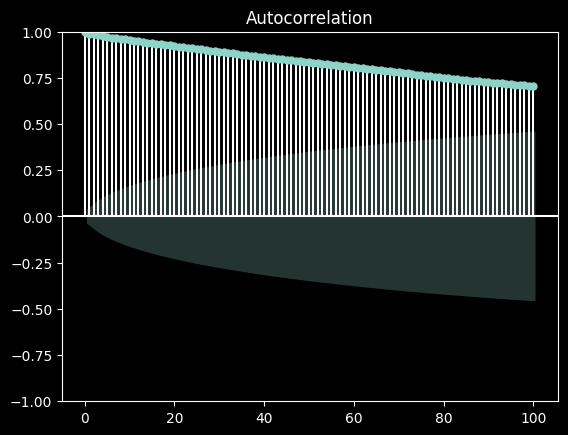

In [504]:
import statsmodels.api as sm
# Compute autocorrelation
acf_values = sm.tsa.acf(gold['gold_price'], nlags=100)

# Plot the results
sm.graphics.tsa.plot_acf(gold['gold_price'], lags=100)
plt.show()



The durbin watson test would indicate that there is presence of positive autocorrelation as the output value is less 2. The ACF plot also shows that a lag of 30 days yields an autocorrelation value outside the confidence interval range, signifying autocorrelation.